Code Adapted from:

https://github.com/aqibsaeed/Entity-Embedding-with-LSTM-for-Time-Series

https://github.com/prince381/air-pollution/blob/master/Beijin%20Air%20quality%20(predicting%20PM2.5).ipynb

https://github.com/swarnava-96/Time-Series/blob/main/Time_Series_with_XgBoost_vs_Fbprophet.ipynb

# Imports

In [112]:
!source ../setup.sh

In [113]:
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))

In [114]:
from utils import DataWrapper, Visualizer

In [115]:
import warnings
warnings.filterwarnings("ignore")

In [137]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor,GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import mean_squared_error as MSE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree

# Data Loading and Pre-Processing

---
We mimic the general pipeline prepare_data function

In [85]:
from src.prepare_dataset import prepare_data
prepare_data("../data/final_dataset_aggregated.csv", "./checking2")

../data/final_dataset_aggregated.csv


2024-07-28 17:35:43.773 | INFO     | src.prepare_dataset:prepare_data:31 - Dropped the unnecessary columns
2024-07-28 17:35:43.774 | INFO     | src.prepare_dataset:prepare_data:36 - Dataset size BEFORE dropping the rows by date: 28299
2024-07-28 17:35:43.825 | INFO     | src.prepare_dataset:prepare_data:38 - Dataset size AFTER dropping the rows by date: 28026
2024-07-28 17:35:43.855 | INFO     | src.prepare_dataset:prepare_data:54 - Overall encoded 5 categorical features
2024-07-28 17:35:43.855 | INFO     | src.prepare_dataset:prepare_data:55 - ['power_on', 'classroom_type', 'break_time', 'school_day', 'school_hours']
2024-07-28 17:35:43.876 | INFO     | src.prepare_dataset:prepare_data:76 - Filled the missing values of variables
2024-07-28 17:35:43.877 | INFO     | src.prepare_dataset:prepare_data:78 - Sliced the data into train and teset
2024-07-28 17:35:43.889 | INFO     | src.prepare_dataset:prepare_data:83 - Applied the MinMaxScaler to numerical features
2024-07-28 17:35:43.890 | 

In [144]:
# Load data into a Pandas data frame.
file_path = '../data/final_dataset_aggregated.csv'
data = pd.read_csv(file_path)


# Convert 'Date' and 'Time' columns to datetime
data['DateTime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], format='%d/%m/%Y %H:%M:%S')

# Extract date and time features
data['Month'] = data['DateTime'].dt.month
data['Day'] = data['DateTime'].dt.day
data['Hour'] = data['DateTime'].dt.hour

# # Filter the DataFrame based on the date range
start_date = '2023-03-16'
end_date = '2023-11-07'
data = data[(data['DateTime'] >= start_date) & (data['DateTime'] <= end_date)]

# Drop original 'Date' and 'Time' columns
data.drop(['Date', 'Time', 'DateTime','Outdoor Temperature_mean','Outdoor Temperature_min','Outdoor Temperature_max','Classroom Category','Device Code','Measured RH_min','Measured RH_mean','Measured RH_max','Measured CO2_min','Measured CO2_mean','Measured CO2_max','Measured PM1.0_min','Measured PM1.0_mean','Measured PM1.0_max','Measured PM2.5_min','Measured PM2.5_mean','Measured PM2.5_max','Measured PM10_min','Measured PM10_mean','Measured PM10_max','Grade','Room No','BattV_Min_min','BattV_Min_mean','BattV_Min_max','Batt24V_Min_min','Batt24V_Min_mean','Batt24V_Min_max','School No','Tracker2WM_Avg_min','Tracker2WM_Avg_mean','Tracker2WM_Avg_max'], axis=1, inplace=True)

# Fill all the null values using forward fill method
data.fillna(method='ffill', inplace=True)
data.isnull().sum()    


Classroom Type           0
Measured T_mean          0
Measured T_min           0
Measured T_max           0
School Day               0
School Hours             0
Break Time               0
Power On                 0
TmStamp                  0
TrackerWM_Avg_mean       0
TrackerWM_Avg_min        0
TrackerWM_Avg_max        0
ShadowWM_Avg_mean        0
ShadowWM_Avg_min         0
ShadowWM_Avg_max         0
SunWM_Avg_mean           0
SunWM_Avg_min            0
SunWM_Avg_max            0
ShadowbandWM_Avg_mean    0
ShadowbandWM_Avg_min     0
ShadowbandWM_Avg_max     0
DNICalc_Avg_mean         0
DNICalc_Avg_min          0
DNICalc_Avg_max          0
AirTC_Avg_mean           0
AirTC_Avg_min            0
AirTC_Avg_max            0
RH_mean                  0
RH_min                   0
RH_max                   0
WS_ms_S_WVT_mean         0
WS_ms_S_WVT_min          0
WS_ms_S_WVT_max          0
WindDir_D1_WVT_mean      0
WindDir_D1_WVT_min       0
WindDir_D1_WVT_max       0
WindDir_SD1_WVT_mean     0
W

In [87]:
# na_records = data[(data['TrackerWM_Avg_mean'].notna()) & 
#                   (data['Month'] == 5) & 
#                   (data['Day'] == 8) & 
#                   (data['Hour'] == 15)]
# na_records

,Classroom Type,Measured T_mean,Measured T_min,Measured T_max,School Day,School Hours,Break Time,Power On,TmStamp,TrackerWM_Avg_mean,...,BP_mB_Avg_max,UVA_Avg_mean,UVA_Avg_min,UVA_Avg_max,UVB_Avg_mean,UVB_Avg_min,UVB_Avg_max,Month,Day,Hour
5837,Brick Second Floor,19.900000,19.9,19.9,Y,N,N,On,08/05/2023 15:49,383.938423,...,1004.81946,0.144363,0.144363,0.144363,0.009372,0.009368,0.009391,5,8,15
5838,Brick Single Story,20.680000,20.6,20.7,Y,N,N,On,08/05/2023 15:52,383.938423,...,1004.80145,0.144363,0.144363,0.144363,0.009368,0.009368,0.009368,5,8,15
5839,Container No Insulation,23.950000,23.7,24.2,Y,N,N,On,08/05/2023 15:30,383.938423,...,1004.76760,0.144363,0.144363,0.144363,0.009368,0.009368,0.009368,5,8,15
5840,Mobile/Prefab,21.057143,19.8,22.2,Y,N,N,On,08/05/2023 15:57,383.938423,...,1004.83870,0.144363,0.144363,0.144363,0.009549,0.009368,0.011853,5,8,15


In [145]:
from typing import Union, Optional, Tuple, List

def preprocess_categorical(data, categorical):
    for cat in categorical:
        le = LabelEncoder()
        data[cat] = le.fit_transform(data[cat])

    return data

# def preprocess_numerical(x_train, x_test, numeric):
#     for num in numeric:
#         ms = MinMaxScaler(feature_range=(0, 1))
#         x_train[num] = ms.fit_transform(x_train[[num]])
#         x_test[num] = ms.transform(x_test[[num]])
#     return x_train, x_test

# def min_max_scale(x: Union[np.array, pd.Series], scaler: Optional[MinMaxScaler] = None) -> Tuple[Union[np.array, pd.Series], MinMaxScaler]:
#     if scaler is None:
#         scaler = MinMaxScaler(feature_range=(0, 1))
#         x_scaled = scaler.fit_transform(x)
#         return x_scaled, scaler
#     return scaler.transform(x), scaler

# def min_max_scale_data(train_df: pd.DataFrame, test_df: pd.DataFrame, columns: List[str], output_dir: str = 'stats') -> Tuple[pd.DataFrame, pd.DataFrame, MinMaxScaler]:
#     if not os.path.exists(output_dir):
#         os.makedirs(output_dir)

#     for col in columns:
#         train_df[col], scaler = min_max_scale(train_df[[col]])
#         test_df[col], _ = min_max_scale(test_df[[col]], scaler)

#         # Save the scaler parameters to a CSV file
#         scaler_params = pd.DataFrame({'min': scaler.data_min_, 'max': scaler.data_max_}, index=[0])
#         scaler_params.to_csv(os.path.join(output_dir, f'{col}_scaler.csv'), index=False)

#     return train_df, test_df
def min_max_scale(x: Union[np.array, pd.Series], scaler: Optional[MinMaxScaler] = None) -> Tuple[Union[np.array, pd.Series], MinMaxScaler]:
    """
    Scales the input data to a given range [0, 1] using min-max scaling.

    Args:
        x (Union[np.array, pd.Series]): The input data series or array.
        scaler (Optional[MinMaxScaler]): The min max scaler. If None, it is calculated from the data.

    Returns:
        Tuple[Union[np.array, pd.Series], MinMaxScaler]: A tuple containing the scaled data and a scaler.
    """
    if scaler is None:
        scaler = MinMaxScaler(feature_range=(0, 1))
        x_scaled = scaler.fit_transform(x)
        return x_scaled, scaler
    return scaler.transform(x), scaler

class DataWrapper:
    def __init__(self, train_df: pd.DataFrame, test_df: pd.DataFrame, output_dir: str = 'stats'):
        self._train_df = train_df
        self._test_df = test_df
        self.output_dir = output_dir

        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)

    def min_max_scale_data(self, columns: List[str]):
        """
        Scales the training and test DataFrames using min-max scaling with the minimum and maximum values of the training data.
        
        The minimum and maximum values are calculated from the training data and then applied to the test data to scale them.
        The scaler is also saved as CSV files in the 'stats' directory within the output directory.
        """
        for col in columns:
            self._train_df[col], scaler = min_max_scale(self._train_df[[col]])
            self._test_df[col], _ = min_max_scale(self._test_df[[col]], scaler)

            # Save the scaler parameters to a CSV file
            scaler_params = pd.DataFrame({'min': scaler.data_min_, 'max': scaler.data_max_}, index=[0])
            scaler_params.to_csv(os.path.join(self.output_dir, f'{col}_scaler.csv'), index=False)

            # # Save the scaler using joblib
            # joblib.dump(scaler, os.path.join(self.output_dir, f'{col}_min_max_scaler.joblib'))



# Single Horizon Forecasting

---
**Predicting for a specific date:**
*   Ensemble Models Tested: Decision Tree, Random Forest, Extra Trees, AdaBoost, and XGBoost.

In [148]:
date_time = ['Month','Day', 'Hour']
numeric = ['TrackerWM_Avg_mean','ShadowWM_Avg_mean','SunWM_Avg_mean', 'ShadowbandWM_Avg_mean', 'DNICalc_Avg_mean','AirTC_Avg_mean','RH_mean', 'WS_ms_S_WVT_mean','WindDir_D1_WVT_mean', 'WindDir_SD1_WVT_mean', 'BP_mB_Avg_mean', 'UVA_Avg_mean','UVB_Avg_mean']
categorical = ['Classroom Type', 'School Day', 'School Hours', 'Break Time', 'Power On']
label = ['Measured T_mean']

#1) Encoding
data = preprocess_categorical(data, categorical)

#2) Train-Test Split
data = data.sort_values(by='TmStamp')
train_percent = 0.8       # percentage of data for training, rest will be for testing
train_split = int(len(data)*train_percent)
train = data[:train_split] # training dataset
test  = data[train_split:]   # testing dataset

# Separate features and label
x_train = train[categorical + numeric + date_time]
y_train = train[['Measured T_mean']]

x_test = test[categorical + numeric + date_time]
y_test = test[['Measured T_mean']]

#3) Optional: Feature Scaling i.e. tree based algorithms don't require this

 #scale data using minmax scaler
# def scale_data(train, test):
#   scaler = MinMaxScaler(feature_range = (0,1))
#   scaler = scaler.fit(np.array(train))

#   train = np.array(train).reshape(train.shape[0], train.shape[1])
#   train_scaled = scaler.transform(train)

#   test = np.array(test).reshape(test.shape[0], test.shape[1])
#   test_scaled = scaler.transform(test)

#   return scaler, train_scaled, test_scaled

def scale_data(train, test, variables):
    scalers = {}
    for var in variables:
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaler.fit(np.array(train[[var]]).reshape(-1, 1))

        train[var] = scaler.transform(np.array(train[[var]]).reshape(-1, 1))
        test[var] = scaler.transform(np.array(test[[var]]).reshape(-1, 1))

        scalers[var] = scaler

    return scalers, train, test

x_train, x_test= scale_data(x_train, x_test, numeric)
y_train, y_test= scale_data(y_train, y_test, label)

# num_scalers = {}
# for num in numeric:
#     scaler = MinMaxScaler(feature_range=(0, 1))
#     x_train[num] = scaler.fit_transform(x_train[[num]])
#     x_test[num] = scaler.transform(x_test[[num]])
#     num_scalers[num] = scaler

# y_scaler = MinMaxScaler(feature_range=(0, 1))
# y_train[label] = y_scaler.fit_transform(y_train)
# y_test[label] = y_scaler.transform(y_test)

# # Initialize DataWrapper and scale numerical features
# wrapper = DataWrapper(x_train, x_test)
# wrapper.min_max_scale_data(numeric)

# # Scale label
# y_train, y_scaler = min_max_scale(y_train)
# y_test, _ = min_max_scale(y_test, y_scaler)


ValueError: too many values to unpack (expected 2)

In [120]:
# Print shapes of the datasets.
print(f"X_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (22420, 21)
y_train shape: (22420, 1)
X_test shape: (5606, 21)
y_test shape: (5606, 1)


In [91]:
y_train

,Measured T_mean
2240,21.100000
2241,19.150000
2242,19.100000
2265,18.066667
2266,17.275000
...,...
26614,19.450000
26612,23.360000
26615,17.685185
26662,22.975000


In [121]:

# Convert scaled numpy arrays back to DataFrame
y_train = pd.DataFrame(y_train, columns=label)
y_test = pd.DataFrame(y_test, columns=label)

combined_train = pd.concat([x_train, y_train], axis=1)
combined_train.to_csv('combined_train55.csv', index=False)

combined_test = pd.concat([x_test, y_test], axis=1)
combined_test.to_csv('combined_test55.csv', index=False)

In [122]:
# Initializing the models.

rf_reg = RandomForestRegressor(random_state=42)
et_reg = ExtraTreesRegressor(random_state=42)
ab_reg = AdaBoostRegressor(random_state=42)
dt_reg = DecisionTreeRegressor(random_state=42)
xg_reg = XGBRegressor(random_state=42)

models = {
    'Random Forest': rf_reg,
    'Extra Trees': et_reg,
    'AdaBoost': ab_reg,
    'Decision Tree': dt_reg,
    'XGBoost': xg_reg
}

In [123]:
# Dictionary to store mean R2 scores and standard deviations.
results = {}

# Iterate over each model.
for model_name, model in models.items():
    # Fit the model on the training data.
    model.fit(x_train, y_train)

    # Predict on the training data.
    y_train_pred = model.predict(x_train)

    # Calculate R2 score on the training data.
    r2_train = r2_score(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)

   # Predict on the test data.
    y_pred = model.predict(x_test)

    # Calculate R2 score on the test data.
    r2_test = r2_score(y_test, y_pred)
    mae_test = mean_absolute_error(y_test, y_pred)

    print(f"{model_name} Train R2: {r2_train:.4f} Test R2 {r2_test:.4f} Train MAE: {mae_train:.4f} Test MAE {mae_test:.4f}")

Random Forest Train R2: 0.9932 Test R2 0.8186 Train MAE: 0.2233 Test MAE 1.2748
Extra Trees Train R2: 1.0000 Test R2 0.8655 Train MAE: 0.0000 Test MAE 1.0843
AdaBoost Train R2: 0.7730 Test R2 0.7267 Train MAE: 1.5571 Test MAE 1.6967
Decision Tree Train R2: 1.0000 Test R2 0.6357 Train MAE: 0.0000 Test MAE 1.7492
XGBoost Train R2: 0.9772 Test R2 0.8578 Train MAE: 0.4520 Test MAE 1.1164


**Observations:** Based on the R2 and MAE score, we will select Extra Trees and employee GridSearch with Time-Series Split Cross Validation to find the optimal hyperparameters.

In [124]:
models = {
    'Extra Trees': et_reg,
}

# Hyperparameters for tuning.
param_grid_et = {
    "n_estimators": [50, 100, 200],               # Number of trees in the forest
    "max_depth": [None, 5, 10, 20],               # Maximum depth of the trees
    "random_state": [42]                          # Random seed for reproducibility
}

param_grid_dt = {
    "max_depth": [3, 5, 10, 20, None],            # Maximum depth of the tree
    "random_state": [42]                          # Random seed for reproducibility
}

# Create a dictionary with model names as keys and hyperparameter grids as values
models_params = {
    "Extra Trees": (et_reg, param_grid_et),
}

Hyper Parameter Tuning

In [125]:
# TimeSeriesSplit setup
tscv = TimeSeriesSplit(n_splits=2)

for model_name, (model, param_grid) in models_params.items():
    grid_search = GridSearchCV(model, param_grid=param_grid, cv=tscv, scoring="r2", verbose=3)
    grid_search.fit(x_train, y_train)

    print(f"Best Hyperparameters for {model_name}:", grid_search.best_params_)

Fitting 2 folds for each of 12 candidates, totalling 24 fits
[CV 1/2] END max_depth=None, n_estimators=50, random_state=42;, score=0.818 total time=   1.0s
[CV 2/2] END max_depth=None, n_estimators=50, random_state=42;, score=0.876 total time=   2.0s
[CV 1/2] END max_depth=None, n_estimators=100, random_state=42;, score=0.821 total time=   1.9s
[CV 2/2] END max_depth=None, n_estimators=100, random_state=42;, score=0.880 total time=   4.0s
[CV 1/2] END max_depth=None, n_estimators=200, random_state=42;, score=0.824 total time=   3.7s
[CV 2/2] END max_depth=None, n_estimators=200, random_state=42;, score=0.881 total time=   7.8s
[CV 1/2] END max_depth=5, n_estimators=50, random_state=42;, score=0.654 total time=   0.2s
[CV 2/2] END max_depth=5, n_estimators=50, random_state=42;, score=0.748 total time=   0.3s
[CV 1/2] END max_depth=5, n_estimators=100, random_state=42;, score=0.662 total time=   0.3s
[CV 2/2] END max_depth=5, n_estimators=100, random_state=42;, score=0.757 total time=   

In [126]:
# Initialize the model with the best hyperparameters.
et_reg = ExtraTreesRegressor(max_depth=20, n_estimators=200, random_state=42)

In [131]:
#  Function to fit a model to the training data, make predictions on the test data, and display performance metrics.
def model_fit(model):
  model.fit(x_train, y_train)
  y_pred = model.predict(x_test)
  r2 = r2_score(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)

  print(f"R² score: {r2:.4f}")
  print(f"Test Mean Squared Error (MSE): {mse:.4f}")
  print(f"Test Mean Absolute Error (MAE): {mae:.4f}")

In [136]:
# Check the performance of Extra Trees on the test data.
model_fit(et_reg)

AttributeError: 'ExtraTreesRegressor' object has no attribute 'best_estimator_'

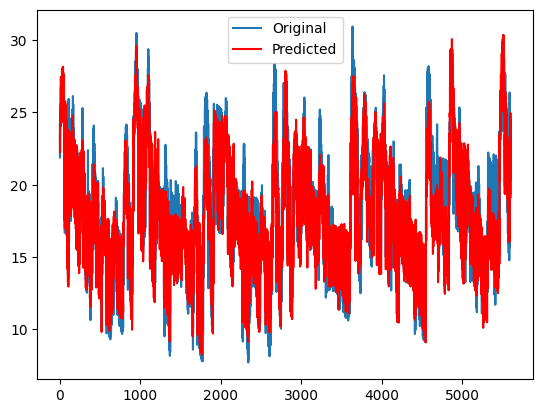

In [129]:
# Lets plot the actual vs predicted values
plt.plot(y_test.values, label = "Original")
plt.plot(y_pred, label = "Predicted", color = "red")
plt.legend();

# DecisionTreeRegressor

In [100]:
decision_tree = DecisionTreeRegressor(max_depth=5,
                                     min_samples_split=3,
                                     min_samples_leaf=2)
decision_tree.fit(x_train,y_train)

DecisionTreeRegressor(max_depth=5, min_samples_leaf=2, min_samples_split=3)

In [101]:
# we now score the model
print('Score on train data: {}\n'.format(decision_tree.score(x_train,y_train)))
print('Score on test data: {}\n'.format(decision_tree.score(x_test,y_test)))

tree_pred = decision_tree.predict(x_test)
tree_mse = mean_squared_error(y_test,tree_pred)
tree_accuracy = r2_score(y_test,tree_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(tree_mse)))
print('Overall model accuracy: {}'.format(tree_accuracy))

Score on train data: 0.7933203274289824

Score on test data: 0.7207875442558163

Root Mean Squared Error: 2.0920412683082588

Overall model accuracy: 0.7207875442558163


In [102]:
# We now tune the parameters of the model to see if we can increase the accuracy
params = {'max_depth':[4,5,6,7,8,9,10],
         'max_features':[None,'sqrt','log2'],
         'min_samples_split':[2,3,4,5,6,7,8,9,10],
         'min_samples_leaf':[2,3,4,5,6,7,8,9,10]}

tree = DecisionTreeRegressor()

# initialize the grid search for the best parameters
tree_search = GridSearchCV(tree,param_grid=params,
                          n_jobs=-1,cv=5)

tree_search.fit(x_train,y_train)   # fit the model

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [4, 5, 6, 7, 8, 9, 10],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]})

In [103]:
# we now score the model
print('Score on train data: {}\n'.format(tree_search.score(x_train,y_train)))
print('Score on test data: {}\n'.format(tree_search.score(x_test,y_test)))
print('Best parameters found:')
display(tree_search.best_params_)

tree_search_pred = tree_search.predict(x_test)
tree_search_mse = mean_squared_error(y_test,tree_search_pred)
tree_search_accuracy = r2_score(y_test,tree_search_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(tree_search_mse)))
print('Overall model accuracy: {}'.format(tree_search_accuracy))

Score on train data: 0.9220931423918712

Score on test data: 0.7538099859978273

Best parameters found:


{'max_depth': 10,
 'max_features': None,
 'min_samples_leaf': 10,
 'min_samples_split': 10}

Root Mean Squared Error: 1.9644368381091875

Overall model accuracy: 0.7538099859978273


# GradientBoostingRegressor

In [104]:
# instantiate the GradientBoostingRegressor model and fit the model on the training data
grad_boost = GradientBoostingRegressor(n_estimators=100,
                                      max_depth=7,
                                      max_features=None,
                                      min_samples_split=7,
                                      min_samples_leaf=3,
                                      learning_rate=0.1)

grad_boost.fit(x_train,y_train)

GradientBoostingRegressor(max_depth=7, min_samples_leaf=3, min_samples_split=7)

In [105]:
# we now score the model
print('Score on train data: {}\n'.format(grad_boost.score(x_train,y_train)))
print('Score on test data: {}\n'.format(grad_boost.score(x_test,y_test)))

gboost_pred = grad_boost.predict(x_test)
gboost_mse = mean_squared_error(y_test,gboost_pred)
gboost_accuracy = r2_score(y_test,gboost_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(gboost_mse)))
print('Overall model accuracy: {}'.format(gboost_accuracy))

Score on train data: 0.9750662413788381

Score on test data: 0.8638353352908406

Root Mean Squared Error: 1.4609490273566164

Overall model accuracy: 0.8638353352908406


In [106]:
# we now tune the parameters of the GradientBoostingRegressor model using RandomizedSearchCV to 
# find the best parameters and increase the accuracy of the model

params['learning_rate'] = np.linspace(0.1,1,10)

# instantiate the model
gradient_boosting = GradientBoostingRegressor()

# perform the grid search for the best parameters
gboost_search = RandomizedSearchCV(gradient_boosting,params,n_jobs=-1,
                                   cv=5,verbose=2)
gboost_search.fit(x_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Use

[CV] END learning_rate=0.6, max_depth=10, max_features=log2, min_samples_leaf=9, min_samples_split=7; total time=   4.8s
[CV] END learning_rate=0.6, max_depth=10, max_features=log2, min_samples_leaf=9, min_samples_split=7; total time=   4.9s
[CV] END learning_rate=0.6, max_depth=10, max_features=log2, min_samples_leaf=9, min_samples_split=7; total time=   5.0s
[CV] END learning_rate=0.6, max_depth=10, max_features=log2, min_samples_leaf=9, min_samples_split=7; total time=   5.0s


/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Use

[CV] END learning_rate=0.6, max_depth=10, max_features=log2, min_samples_leaf=9, min_samples_split=7; total time=   5.1s


/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


[CV] END learning_rate=0.30000000000000004, max_depth=8, max_features=sqrt, min_samples_leaf=9, min_samples_split=8; total time=   3.8s
[CV] END learning_rate=0.30000000000000004, max_depth=8, max_features=sqrt, min_samples_leaf=9, min_samples_split=8; total time=   4.0s
[CV] END learning_rate=0.30000000000000004, max_depth=8, max_features=sqrt, min_samples_leaf=9, min_samples_split=8; total time=   4.1s


/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


[CV] END learning_rate=0.9, max_depth=7, max_features=log2, min_samples_leaf=6, min_samples_split=3; total time=   3.4s


/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


[CV] END learning_rate=0.4, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=5; total time=  12.8s
[CV] END learning_rate=0.4, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=5; total time=  13.0s


/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


[CV] END learning_rate=0.4, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=5; total time=  13.2s
[CV] END learning_rate=0.30000000000000004, max_depth=8, max_features=sqrt, min_samples_leaf=9, min_samples_split=8; total time=   4.2s
[CV] END learning_rate=0.30000000000000004, max_depth=8, max_features=sqrt, min_samples_leaf=9, min_samples_split=8; total time=   4.2s


/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


[CV] END learning_rate=0.9, max_depth=7, max_features=log2, min_samples_leaf=6, min_samples_split=3; total time=   3.8s


/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


[CV] END learning_rate=0.9, max_depth=7, max_features=log2, min_samples_leaf=6, min_samples_split=3; total time=   3.9s
[CV] END learning_rate=0.9, max_depth=7, max_features=log2, min_samples_leaf=6, min_samples_split=3; total time=   3.8s


/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


[CV] END learning_rate=0.9, max_depth=7, max_features=log2, min_samples_leaf=6, min_samples_split=3; total time=   3.8s


/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


[CV] END learning_rate=0.8, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=10; total time=   4.5s


/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


[CV] END learning_rate=0.8, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=10; total time=   4.6s


/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


[CV] END learning_rate=0.4, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=5; total time=  13.6s
[CV] END learning_rate=0.4, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=5; total time=  13.8s


/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


[CV] END learning_rate=0.8, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=10; total time=   4.4s


/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


[CV] END learning_rate=0.8, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=10; total time=   4.3s
[CV] END learning_rate=0.8, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=10; total time=   4.3s


/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


[CV] END learning_rate=0.8, max_depth=8, max_features=log2, min_samples_leaf=4, min_samples_split=6; total time=   4.7s
[CV] END learning_rate=0.8, max_depth=8, max_features=log2, min_samples_leaf=4, min_samples_split=6; total time=   4.5s


/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


[CV] END learning_rate=0.8, max_depth=8, max_features=log2, min_samples_leaf=4, min_samples_split=6; total time=   4.7s


/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


[CV] END learning_rate=0.8, max_depth=8, max_features=log2, min_samples_leaf=4, min_samples_split=6; total time=   4.5s
[CV] END learning_rate=0.8, max_depth=8, max_features=log2, min_samples_leaf=4, min_samples_split=6; total time=   4.9s


/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


[CV] END learning_rate=1.0, max_depth=5, max_features=None, min_samples_leaf=10, min_samples_split=4; total time=  14.3s


/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


[CV] END learning_rate=1.0, max_depth=5, max_features=None, min_samples_leaf=10, min_samples_split=4; total time=  14.5s


/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


[CV] END learning_rate=1.0, max_depth=5, max_features=None, min_samples_leaf=10, min_samples_split=4; total time=  14.5s


/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


[CV] END learning_rate=1.0, max_depth=5, max_features=None, min_samples_leaf=10, min_samples_split=4; total time=  14.3s


/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


[CV] END learning_rate=1.0, max_depth=5, max_features=None, min_samples_leaf=10, min_samples_split=4; total time=  14.5s


/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


[CV] END learning_rate=0.9, max_depth=9, max_features=log2, min_samples_leaf=4, min_samples_split=10; total time=   4.7s


/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


[CV] END learning_rate=0.9, max_depth=9, max_features=log2, min_samples_leaf=4, min_samples_split=10; total time=   4.5s


/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


[CV] END learning_rate=0.9, max_depth=9, max_features=log2, min_samples_leaf=4, min_samples_split=10; total time=   4.7s


/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


[CV] END learning_rate=0.30000000000000004, max_depth=6, max_features=sqrt, min_samples_leaf=6, min_samples_split=9; total time=   3.0s


/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


[CV] END learning_rate=0.9, max_depth=9, max_features=log2, min_samples_leaf=4, min_samples_split=10; total time=   4.4s


/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


[CV] END learning_rate=0.9, max_depth=9, max_features=log2, min_samples_leaf=4, min_samples_split=10; total time=   4.5s


/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


[CV] END learning_rate=0.30000000000000004, max_depth=6, max_features=sqrt, min_samples_leaf=6, min_samples_split=9; total time=   3.1s


/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


[CV] END learning_rate=0.30000000000000004, max_depth=6, max_features=sqrt, min_samples_leaf=6, min_samples_split=9; total time=   3.0s
[CV] END learning_rate=0.30000000000000004, max_depth=6, max_features=sqrt, min_samples_leaf=6, min_samples_split=9; total time=   3.1s
[CV] END learning_rate=0.30000000000000004, max_depth=6, max_features=sqrt, min_samples_leaf=6, min_samples_split=9; total time=   3.1s
[CV] END learning_rate=0.9, max_depth=9, max_features=None, min_samples_leaf=7, min_samples_split=2; total time=  22.8s
[CV] END learning_rate=0.9, max_depth=9, max_features=None, min_samples_leaf=7, min_samples_split=2; total time=  22.2s
[CV] END learning_rate=0.9, max_depth=9, max_features=None, min_samples_leaf=7, min_samples_split=2; total time=  22.0s
[CV] END learning_rate=0.9, max_depth=9, max_features=None, min_samples_leaf=7, min_samples_split=2; total time=  22.0s
[CV] END learning_rate=0.9, max_depth=9, max_features=None, min_samples_leaf=7, min_samples_split=2; total time=

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
                   param_distributions={'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'max_depth': [4, 5, 6, 7, 8, 9, 10],
                                        'max_features': [None, 'sqrt', 'log2'],
                                        'min_samples_leaf': [2, 3, 4, 5, 6, 7,
                                                             8, 9, 10],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10]},
                   verbose=2)

In [107]:
# we now score the model
print('Score on train data: {}\n'.format(gboost_search.score(x_train,y_train)))
print('Score on test data: {}\n'.format(gboost_search.score(x_test,y_test)))
print('Best parameters found:')
display(gboost_search.best_params_)

gboost_search_pred = gboost_search.predict(x_test)
gboost_search_mse = mean_squared_error(y_test,gboost_search_pred)
gboost_search_accuracy = r2_score(y_test,gboost_search_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(gboost_search_mse)))
print('Overall model accuracy: {}'.format(gboost_search_accuracy))

Score on train data: 0.9666236369756517

Score on test data: 0.8361502094881421

Best parameters found:


{'min_samples_split': 5,
 'min_samples_leaf': 5,
 'max_features': None,
 'max_depth': 5,
 'learning_rate': 0.4}

Root Mean Squared Error: 1.6026024353069055

Overall model accuracy: 0.8361502094881421


# XGBoost

In [138]:
# Model Training
reg = XGBRegressor(objective = "reg:squarederror", n_estimators = 1000)
reg.fit(x_train, y_train, verbose = True)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [139]:
# Prediction
yhat = reg.predict(x_test)
print(yhat)

[22.76126  23.012045 22.32993  ... 21.594185 23.395094 23.925077]


In [140]:
# Model Evaluation
rmse = np.sqrt(MSE(y_test, yhat))
print("RMSE: %f" %(rmse))

RMSE: 1.568449


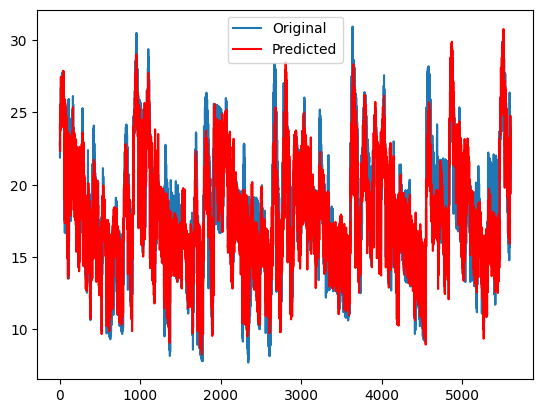

In [141]:
# Lets plot the actual vs predicted values
plt.plot(y_test.values, label = "Original")
plt.plot(yhat, label = "Predicted", color = "red")
plt.legend();

In [143]:
# Hyper parameter optimization
params = {
    'min_child_weight': [4, 5],
    'gamma': [i / 10.0 for i in range(3, 6)],
    'subsample': [i / 10.0 for i in range(6, 11)],
    'colsample_bytree': [i / 10.0 for i in range(6, 11)],
    'max_depth': [2, 3, 4]
}
# Initialize XGB and GridSearch
xgb_reg = XGBRegressor(nthread=-1, objective='reg:squarederror')
grid = GridSearchCV(xgb_reg, params)
grid.fit(x_train, y_train)
gridcv_xgb = grid.best_estimator_
print(r2_score(y_test, gridcv_xgb.predict(x_test)))

0.863177478313446


In [ ]:
# Prediction
yhat = grid.predict(x_test)

In [ ]:
# Evaluation
rmse = np.sqrt(MSE(y_test, yhat))
print("RMSE : % f" %(rmse))

In [ ]:
# Actual vs Predicted
plt.plot(y_test.values, label='Original')
plt.plot(yhat, color='red', label='Predicted')
plt.legend();